# Task 1.1: Data understanding

In [1]:
#Used for displaying plots below the cell
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0)

In [3]:
df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,"2,55",17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,"2,75",17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


The dataset seems to contain data about the shopping habits of the customers of a grocery store chain.  
Each row represents an object purchased:  
- BasketID: identifies a batch of items bought during the same shopping session  
- BasketDate: date in which the shopping session took place  
- Sale: represents the value of the item, we need to figure out if it refers to a single item or the item*quantity
- CustomerID: identifies a unique customer
- CustomerCountry: represents the country in which the purchase took place
- ProdID: identifies a unique product for sale
- ProdDescr: describes the product
- Qta: number of items bought with id ProdID

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         471910 non-null  object 
 1   BasketDate       471910 non-null  object 
 2   Sale             471910 non-null  object 
 3   CustomerID       406830 non-null  float64
 4   CustomerCountry  471910 non-null  object 
 5   ProdID           471910 non-null  object 
 6   ProdDescr        471157 non-null  object 
 7   Qta              471910 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 32.4+ MB


In [5]:
len(df.index)

471910

Only ProdDescr and CustomerID contain null values.

In [6]:
df.describe()

,CustomerID,Qta
count,406830.000000,471910.000000
mean,15287.684160,10.716533
std,1713.603074,231.355136
min,12346.000000,-80995.000000
25%,13953.000000,1.000000
50%,15152.000000,4.000000
75%,16791.000000,12.000000
max,18287.000000,80995.000000


The statistics regarding the CustomerID are meaningless since the assignment of an ID is usually done progressively and without having any additional information on the customer.  
We need to fix the data type situation in order to get a better understanding of the data set.

## Data type conversion  
Let's start by checking out the data type that pandas assigns to the attributes, in order to get an idea of the potential problems.

In [7]:
df.dtypes

BasketID            object
BasketDate          object
Sale                object
CustomerID         float64
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

In [8]:
df.convert_dtypes().dtypes

BasketID           string
BasketDate         string
Sale               string
CustomerID          Int64
CustomerCountry    string
ProdID             string
ProdDescr          string
Qta                 Int64
dtype: object

### CustomerID

CustomerID got converted to a reasonable data type while the others became a generic "string".  
However there is no point in having CustomerID as an int64.

In [9]:
df["CustomerID"] = df["CustomerID"].astype("object")

### BasketDate
Let's convert the BasketDate type from String to datetime, just in case we need to perform some analysis that requires ordinal data.

In [10]:
df.BasketDate = pd.to_datetime(df.BasketDate)

### Sale

The "Sale" attribute is considered a generic object while it should be recognised as a float.  
Let's see why.

In [11]:
df.Sale.map(type)

0         <class 'str'>
1         <class 'str'>
2         <class 'str'>
3         <class 'str'>
4         <class 'str'>
              ...      
541905    <class 'str'>
541906    <class 'str'>
541907    <class 'str'>
541908    <class 'str'>
541909    <class 'str'>
Name: Sale, Length: 471910, dtype: object

In [12]:
df.Sale

0         2,55
1         3,39
2         2,75
3         3,39
4         3,39
          ... 
541905     2,1
541906    4,15
541907    4,15
541908    4,95
541909      18
Name: Sale, Length: 471910, dtype: object

It seems that Sale uses a comma instead of a point to separate the decimal part, so it is considered a "str" instead of a "float64".  
Let's replace the commas in "Sale" with dots in order to have them be recognised as float64 by pandas.

In [13]:
df.Sale = df.Sale.apply(lambda x: x.replace(',','.'))

In [14]:
df.Sale = df.Sale.astype("float64")

Sale is now correctly identified as a float64.

## Data exploration

### Exploration data frame
Used for exploration purposes but not necessarily useful for clustering.  
Initialised with some additional features that could prove useful.

In [15]:
#Auxiliary df to be used throughout the data understanding phase
df_expl = df.copy()

df_expl["QtaPositive"] = 0
df_expl.loc[df_expl["Qta"] > 0, "QtaPositive"] = 1 #Indicates whether the records Qta is positive

df_expl["SalePositive"] = 0
df_expl.loc[df_expl["Sale"] > 0, "SalePositive"] = 1 #Indicates whether the records Sale is positive

df_expl.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,QtaPositive,SalePositive
0,536365,2010-01-12 08:26:00,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1,1
1,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6,1,1
2,536365,2010-01-12 08:26:00,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8,1,1
3,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1,1
4,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1,1


### BasketID

In [16]:
print(f"The number of unique CustomerID is: {len(df['CustomerID'].unique())}")

The number of unique CustomerID is: 4373


#### Regarding the different types of BasketID
Let's check why BasketID is not considered an int64 like CustomerID.

In [17]:
nonNumSeries = pd.to_numeric(df.BasketID, errors='coerce').isnull()
# Print the records with BasketIDs containing a non-numeric value
df[nonNumSeries].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-01-12 09:41:00,27.50,14527,United Kingdom,D,Discount,-1
154,C536383,2010-01-12 09:49:00,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-01-12 10:24:00,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


In [18]:
df.loc[nonNumSeries, "BasketID"].str.slice(0,1).unique()

array(['C', 'A'], dtype=object)

It seems that a good chunk of the BasketID values start with a "C" and some with "A" instead of being just numbers.  

In [19]:
basket_c_df = df.loc[df["BasketID"].str.get(0) == "C"]
len_basket_c = len(basket_c_df)
print(f"Records starting with 'C' (Size: {len_basket_c}):\n")
basket_c_df.head(5)

Records starting with 'C' (Size: 9084):



,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-01-12 09:41:00,27.50,14527,United Kingdom,D,Discount,-1
154,C536383,2010-01-12 09:49:00,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-01-12 10:24:00,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


In [20]:
basket_a_df = df.loc[df["BasketID"].str.get(0) == "A"]
len_basket_a = len(basket_a_df)
print(f"Records starting with 'A' (Size: {len_basket_a}):\n")
basket_a_df.head(10)

Records starting with 'A' (Size: 2):



,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-12-08 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-12-08 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1


There seems to be a strong correlation between the "C" and a negative quantity, this could indicate a customer that asked for a refund.  

There is also some interesting correlation between the "A" start and a ProdDescr containing "Adjust bad debt", maybe the "A" stands for adjust and since the CustomerID in both cases is NaN this could be an operation that concerns only the management of the shop and not something that concerns the customers (which is our primary objective).  
These records, however, are too few to be meaningful, they skew too much the characteristics of the sale data (outliers) and they don't concern the activities of the customers.

Let's try to add a "BasketID type A" and "BasketID type C" binary attribute (0/1) and see if there are correlations.

In [21]:
#Initialise all the cells to 0
df_expl["BasketIDTypeA"] = 0
df_expl["BasketIDTypeC"] = 0
df_expl["BasketIDTypeStd"] = 0

#Set the cells appropriately depending on the BasketID type
df_expl.loc[df_expl["BasketID"].str.get(0) == "A", "BasketIDTypeA"] = 1
df_expl.loc[df_expl["BasketID"].str.get(0) == "C", "BasketIDTypeC"] = 1
df_expl.loc[(df_expl["BasketIDTypeA"] == 0) & (df_expl["BasketIDTypeC"] == 0), "BasketIDTypeStd"] = 1

df_expl["NewBasketID"] = df_expl["BasketID"]

#Remove the initial letter from BasketID where necessary
df_expl.loc[df_expl["BasketID"].str.get(0) == "A", "NewBasketID"] = df_expl.loc[(df_expl["BasketID"].str.get(0) == "A"), "BasketID"].str.slice(start=1)
df_expl.loc[df_expl["BasketID"].str.get(0) == "C", "NewBasketID"] = df_expl.loc[(df_expl["BasketID"].str.get(0) == "C"), "BasketID"].str.slice(start=1)

df_expl.corr()

,Sale,Qta,QtaPositive,SalePositive,BasketIDTypeA,BasketIDTypeC,BasketIDTypeStd
Sale,1.000000,-0.001247,-0.046158,0.013267,-0.271954,0.048286,-0.044207
Qta,-0.001247,1.000000,0.029379,0.009319,-0.000086,-0.024892,0.024891
QtaPositive,-0.046158,0.029379,1.000000,0.183662,0.000299,-0.964446,0.964338
SalePositive,0.013267,0.009319,0.183662,1.000000,-0.039459,0.007309,-0.006717
BasketIDTypeA,-0.271954,-0.000086,0.000299,-0.039459,1.000000,-0.000288,-0.014693
BasketIDTypeC,0.048286,-0.024892,-0.964446,0.007309,-0.000288,1.000000,-0.999888
BasketIDTypeStd,-0.044207,0.024891,0.964338,-0.006717,-0.014693,-0.999888,1.000000


The BasketID of type C has a strong negative correlation with the sign of Qta.

In [22]:
df_expl.loc[df["BasketID"].str.get(0) == "C", "ProdDescr"].unique()

array(['Discount', 'SET OF 3 COLOURED  FLYING DUCKS',
       'PLASTERS IN TIN CIRCUS PARADE ', ...,
       'SMALL SQUARE CUT GLASS CANDLESTICK',
       'HOUSE SHAPE PENCIL SHARPENER', 'PAPER CRAFT , LITTLE BIRDIE'],
      dtype=object)

What could this mean for the C type? Probably indicates discounts/refunds, further checks necessary.

In [23]:
df_expl["NewBasketID"] = df_expl["NewBasketID"].astype("int64")
df_expl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  object        
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
 8   QtaPositive      471910 non-null  int64         
 9   SalePositive     471910 non-null  int64         
 10  BasketIDTypeA    471910 non-null  int64         
 11  BasketIDTypeC    471910 non-null  int64         
 12  BasketIDTypeStd  471910 non-null  int64         
 13  NewBasketID      471910 non-null  int64         
dtypes: datetime64[ns](1)

We notice that there are no more anomalies inside BasketID since it can be now converted to int64.

In [24]:
df_expl["NewBasketID"] = df_expl["NewBasketID"].astype("string")

Let's check if we now have less unique BasketIDs in our records, after removing the letter that identifies the type from the BasketID attribute.

In [25]:
print(f'The original number of unique BasketIDs is: {df_expl["BasketID"].unique().size}')
print(f'The current number of unique BasketIDs is: {df_expl["NewBasketID"].unique().size}')

The original number of unique BasketIDs is: 24627
The current number of unique BasketIDs is: 24627


The number is the same, therefore each BasketID of type A or C didn't merge with pre-existing shopping sessions.

#### Regarding the merger of type C records into standard records
Let's check if it is possible/reasonable to associate each type C record with a standard record with the same ProdID, Sale and CustomerID.  

In [26]:
df_expl["ProdSaleQta"] = df_expl["Qta"]*df_expl["Sale"]
df_expl["AbsProdSaleQta"] = df_expl["ProdSaleQta"].abs()

In [27]:
#Only about 9000 entries to check, computationally feasible
df_typec = df_expl.loc[df_expl["BasketIDTypeC"] == 1].copy()
std_df = df_expl.loc[df_expl["BasketIDTypeStd"] == 1].copy()

#New dataframe that we are going to save and reuse later for further analysis
type_c_id_list = df_typec["BasketID"].sort_values().unique()
refunds_dict = {}

non_refundable_df = pd.DataFrame(columns=std_df.columns)
n_refunded_requests = 0

i = 0
#Increase sample size for a more accurate analysis
#Set to df_typec.shape[0] for a complete check (Warning: takes a while)
sampleSize = 10

for index, series in df_typec.iterrows():
    
    #Constraints
    tmp_df1 = std_df.loc[(std_df["BasketDate"] <= series["BasketDate"]) & 
                         (std_df["Sale"] == series["Sale"]) & 
                         (std_df["CustomerID"] == series["CustomerID"]) & 
                         (std_df["ProdID"] == series["ProdID"])]
    
    tmp_df1 = tmp_df1.sort_values(["BasketDate"], ascending=False)
    
    #Stronger requirement, if present otherwise merge with a record that satisfies the requirements of tmp_df1
    tmp_df2 = tmp_df1.loc[(tmp_df1["AbsProdSaleQta"] == series["AbsProdSaleQta"])]
    #Whenever in doubt about the API properties...
    tmp_df2 = tmp_df2.sort_values(["BasketDate"], ascending=False)
    
    order_found = None

    if(tmp_df2.empty == False):
        #Given the additional constraint the first entry is sufficient
        order_found = tmp_df2.iloc[0]

        std_df.loc[(std_df["BasketID"] == order_found["BasketID"]) & 
                                (std_df["ProdID"] == order_found["ProdID"]), "AbsProdSaleQta"] = 0
        std_df.loc[(std_df["BasketID"] == order_found["BasketID"]) & 
                                (std_df["ProdID"] == order_found["ProdID"]), "Qta"] = 0
        
        #Save result
        #print(order_found["BasketID"])
        refunds_dict[(series["BasketID"], series["ProdID"])] = pd.array([order_found['BasketID']])
        
    elif(tmp_df1.empty == False):
        order_list = []
        amount_to_refund = -1*series["Qta"]
        tmp_i = 0
        
        while(amount_to_refund > 0 and len(tmp_df1.index) > tmp_i):
            order_found = tmp_df1.iloc[tmp_i]
            tmp_i = tmp_i + 1
            
            if(order_found["Qta"] == 0):
                continue
            
            order_list.append(order_found["BasketID"])
            amount_to_refund = amount_to_refund - order_found["Qta"]
            
            #Need to avoid two different refunds referencing the same order without any items left to be refunded
            if(amount_to_refund >= 0):
                tmp_df1.loc[tmp_df1["BasketID"] == order_found["BasketID"], "Qta"] = 0
                std_df.loc[(std_df["BasketID"] == order_found["BasketID"]) & 
                                (std_df["ProdID"] == order_found["ProdID"]), "Qta"] = 0
            else:
                tmp_df1.loc[tmp_df1["BasketID"] == order_found["BasketID"], "Qta"] = -1*amount_to_refund
                std_df.loc[(std_df["BasketID"] == order_found["BasketID"]) & 
                                (std_df["ProdID"] == order_found["ProdID"]), "Qta"] = -1*amount_to_refund
                amount_to_refund = 0
        
        #Save result
        #print(order_list)
        if(amount_to_refund == 0):
            n_refunded_requests = n_refunded_requests + 1
    else:
        #print(f"No match found")
        #print(series)
        #print(std_df.loc[(std_df["CustomerID"] == series["CustomerID"]) & 
        #                 (std_df["Sale"] == series["Sale"]) & 
        #                 (std_df["ProdID"] == series["ProdID"])].head())
        
        non_refundable_df = non_refundable_df.append(series)
        
    #Avoids a long computation on the full dataset
    if(i >= sampleSize):
        break
    
    #print(i)
    i = i+1

In [28]:
print(f"Percentage of entries without a corresponding purchase: {len(non_refundable_df.index)/sampleSize*100}%")

Percentage of entries without a corresponding purchase: 100.0%


The result calculated on the whole subset type C is : 34.58%

Considering the amount of refund entries for which there is no corresponding purchase there seems to be some missing data or our interpretation of type C records is incorrect.  
For this reason we decide to consider type C records as a generic cost, relative to a specific CustomerID, incurred by the supermarket.  
The other entries with negative Qta will be considered as costs that did not originate from the interaction with a particular customer.  
  
The sum of the entries with negative Qta will henceforth be considered as the TotalCost paid by the company while the sum of everything else is the Revenue.

#### Regarding the shopping habits of a customer that returned for a "refund"

In [29]:
grouping_cond = ["CustomerID", pd.Grouper(key="BasketDate", freq="D")]

refund_all_cust_df = df_expl.groupby(grouping_cond).filter(lambda x: (x["BasketIDTypeC"] == 1).any())

refund_and_shop_cust_df = df_expl.groupby(grouping_cond)\
            .filter(lambda x: (x["BasketIDTypeC"] == 1).any() and (x["BasketIDTypeC"] == 0).any())

refund_only_cust_df = df_expl.groupby(grouping_cond).filter(lambda x: (x["BasketIDTypeC"] == 1).all())

In [30]:
refund_all_value = refund_all_cust_df.groupby(grouping_cond).ngroups
refund_and_shop_value = refund_and_shop_cust_df.groupby(grouping_cond).ngroups

print(f"The percentage of times that a customer buys items in the same day when he/she refunds something is: " + \
        f"{refund_and_shop_value/refund_all_value*100}%")

The percentage of times that a customer buys items in the same day when he/she refunds something is: 27.48638578389223%


### BasketDate
Let's see how the entries are distributed over time.

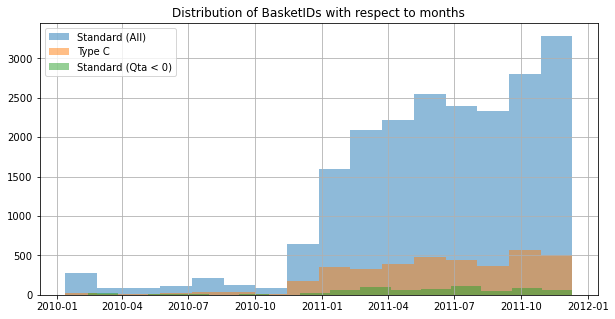

In [31]:
k = math.ceil(math.log(len(df["BasketID"].unique()), 2) + 1) #Sturge's rule


#Since there is only one date for each BasketID take only the first element in each group
df_expl.loc[df_expl["BasketIDTypeStd"] == 1]\
    .groupby(["BasketID"]).nth(0)["BasketDate"].hist(bins=k, figsize=(10,5), alpha=0.5)

df_expl.loc[df_expl["BasketIDTypeC"] == 1].groupby(["BasketID"]).nth(0)["BasketDate"].hist(bins=k, figsize=(10,5), alpha=0.5)

df_expl.loc[(df_expl["BasketIDTypeStd"] == 1) & (df_expl["Qta"] < 0)]\
    .groupby(["BasketID"]).nth(0)["BasketDate"].hist(bins=k, figsize=(10,5), alpha=0.5)


plt.legend(('Standard (All)', 'Type C', 'Standard (Qta < 0)'), loc='best')
plt.title('Distribution of BasketIDs with respect to months')
plt.show()

The number of transactions increases month by month.  
Possibly reflects a change of policy regarding data collection.

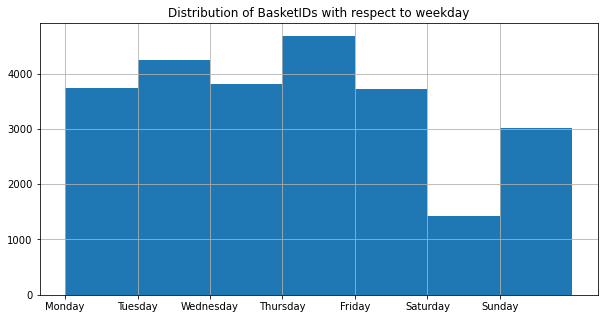

In [32]:
days_dict = dict(zip([0,1,2,3,4,5,6], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]))

basketday = df.groupby(["BasketID"]).nth(0)["BasketDate"].dt.weekday #Series containing the day of the week of each BasketID
basketday = basketday.sort_values().transform(lambda x: days_dict[x])
basketday.hist(bins=np.arange(0, len(days_dict)+1, 1), figsize=(10,5))
plt.title('Distribution of BasketIDs with respect to weekday')
plt.show()

Saturday and sunday seem to be the least active days for the shops.

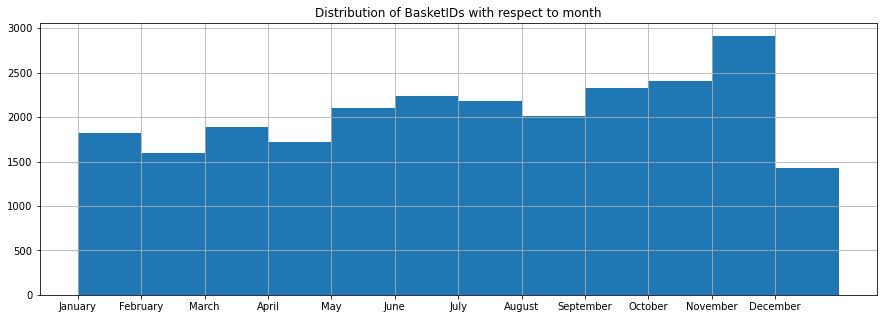

In [33]:
months_dict = dict(zip([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12], 
                       ["January", "February", "March", "April", 
                        "May", "June", "July", "August", 
                        "September", "October", "November", "December"]))

basketmonth = df.groupby(by=["BasketID"]).nth(0)["BasketDate"].dt.month #Series containing the day of the week of each BasketID
basketmonth = basketmonth.sort_values().transform(lambda x: months_dict[x]) #Sort needed to have the correct ordering in the plot
basketmonth.hist(bins=np.arange(0, len(months_dict)+1, 1), figsize=(15,5))
plt.title('Distribution of BasketIDs with respect to month')
plt.show()

The sales peak happens in November and the least amount of sales occurs in December.

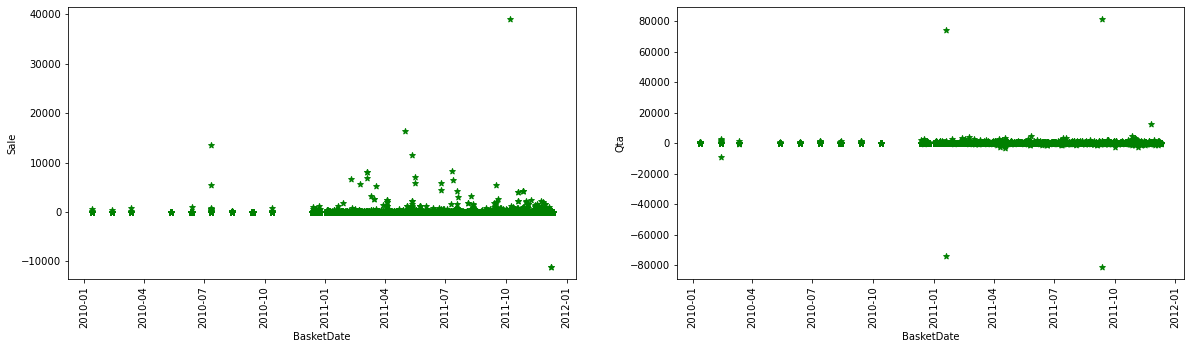

In [34]:
#Distributions of Sale and Qta taking into account the BasketDate
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))

plt.scatter(df_expl["BasketDate"], df_expl["Sale"], color='g', marker='*', label='Standard')

plt.xlabel('BasketDate')
plt.xticks(rotation='vertical')
plt.ylabel('Sale')

plt.subplot2grid(fig_dims, (0, 1))

plt.scatter(df_expl["BasketDate"], df_expl["Qta"], color='g', marker='*', label='Standard')

plt.xlabel('BasketDate')
plt.xticks(rotation='vertical')
plt.ylabel('Qta')

plt.show()

Here are clearly visible data points that could be classified as outliers.

### Sale

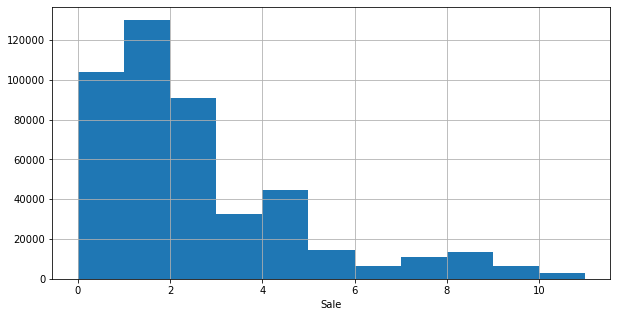

In [35]:
k = math.ceil(math.log(len(df["Sale"].unique()), 2) + 1) #Sturge's rule

df_expl["Sale"].hist(bins=np.arange(0,k), figsize=(10,5))
plt.xlabel("Sale")
plt.show()

In [36]:
df_expl["Sale"].describe()

count    471910.000000
mean          4.030945
std          83.769380
min      -11062.060000
25%           1.250000
50%           2.080000
75%           3.750000
max       38970.000000
Name: Sale, dtype: float64

#### Regarding negative Sale entries

In [37]:
df_expl[df_expl["Sale"] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,QtaPositive,SalePositive,BasketIDTypeA,BasketIDTypeC,BasketIDTypeStd,NewBasketID,ProdSaleQta,AbsProdSaleQta
299983,A563186,2011-12-08 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1,1,0,1,0,0,563186,-11062.06,11062.06
299984,A563187,2011-12-08 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1,1,0,1,0,0,563187,-11062.06,11062.06


The only entries with a negative Sale are the type A entries, of which there are only two in the entire dataset.

#### Regarding the relationship between Sale and Qta
We need to figure out if the Sale value refers to the cost of a single item or cost of item * Qta

In [38]:
df.sort_values(by="ProdID").head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
109443,545637,2011-04-03 12:16:00,0.85,15514,United Kingdom,10002,INFLATABLE POLITICAL GLOBE,2
121872,546790,2011-03-17 10:26:00,0.85,14713,United Kingdom,10002,INFLATABLE POLITICAL GLOBE,6
171573,551429,2011-04-28 15:05:00,0.00,NaN,United Kingdom,10002,NaN,-3
22380,538167,2010-09-12 18:58:00,0.85,14713,United Kingdom,10002,INFLATABLE POLITICAL GLOBE,12
93152,544278,2011-02-17 12:01:00,0.85,15382,United Kingdom,10002,INFLATABLE POLITICAL GLOBE,12


Just by looking at this view of the Data Frame it seems that Sale doesn't change if the Qta changes.

In [39]:
df.corr()

,Sale,Qta
Sale,1.000000,-0.001247
Qta,-0.001247,1.000000


There is no significant correlation between Sale and Qta, we can therefore assume that Sale is the cost of the single item.

#### Regarding Sale values equal to 0  
In the context of sale 0 values don't make sense and therefore should be considered as missing values.

In [40]:
df_expl["SaleNull"] = 0
df_expl.loc[df_expl["Sale"] == 0, "SaleNull"] = 1
n_missing_sale = df_expl.loc[df_expl["Sale"] == 0].shape[0]
n_tot_sale = df["Sale"].shape[0]
print(f"Number of entries with Sale equal to 0: {n_missing_sale}")
print(f"Percentage of entries with Sale equal to 0: {(n_missing_sale/n_tot_sale)*100}%")

Number of entries with Sale equal to 0: 1279
Percentage of entries with Sale equal to 0: 0.27102625500625116%


A small percentage, relative to the entire dataset, of the entries presents a Sale value equal to 0.

In [41]:
df_expl.loc[df_expl["SaleNull"] == 1].describe()

,Sale,Qta,QtaPositive,SalePositive,BasketIDTypeA,BasketIDTypeC,BasketIDTypeStd,ProdSaleQta,AbsProdSaleQta,SaleNull
count,1279.0,1279.000000,1279.000000,1279.0,1279.0,1279.0,1279.0,1279.0,1279.0,1279.0
mean,0.0,-30.657545,0.477717,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,0.0,433.790135,0.499699,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,-2880.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
25%,0.0,-30.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,0.0,-1.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,0.0,3.000000,1.000000,0.0,0.0,0.0,1.0,-0.0,0.0,1.0
max,0.0,12540.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0


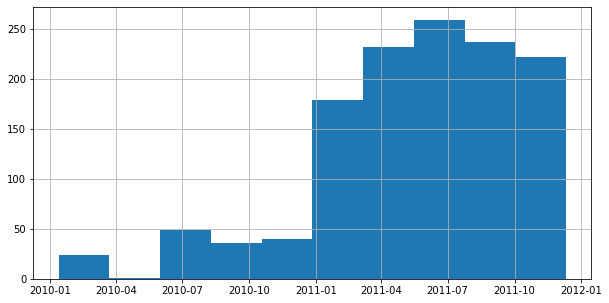

In [42]:
plt.figure(figsize=(10,5))
df_expl.loc[df_expl["SaleNull"] == 1, "BasketDate"].hist()
plt.show()

There doesn't seem to be any apparent pattern to the entries with Sale equal to 0.

### CustomerID

#### Regarding null CustomerIDs
Let's see why the number of non-null CustomerID entries is so low and if there are any interesting properties to be found.

In [43]:
df_expl.loc[df_expl["CustomerID"].isna()].describe()

,Sale,Qta,QtaPositive,SalePositive,BasketIDTypeA,BasketIDTypeC,BasketIDTypeStd,ProdSaleQta,AbsProdSaleQta,SaleNull
count,65080.000000,65080.000000,65080.000000,65080.000000,65080.000000,65080.000000,65080.000000,65080.000000,65080.000000,65080.000000
mean,7.596884,2.310234,0.986985,0.980931,0.000031,0.002750,0.997219,10.456138,15.218025,0.019038
std,144.343755,37.605007,0.113338,0.136768,0.005544,0.052373,0.052664,150.170956,149.763335,0.136660
min,-11062.060000,-2880.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16453.710000,0.000000,0.000000
25%,1.630000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.460000,2.480000,0.000000
50%,3.290000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,4.960000,4.960000,0.000000
75%,5.060000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,10.790000,10.790000,0.000000
max,16453.710000,3100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2653.950000,16453.710000,1.000000


There are 65080 records with a null CustomerID.

In [44]:
df_expl["CustomerIDNull"] = 0
df_expl.loc[df_expl["CustomerID"].isna(), "CustomerIDNull"] = 1

In [45]:
df_expl.corr()["CustomerIDNull"]

Sale               0.017026
Qta               -0.014533
QtaPositive        0.021508
SalePositive      -0.125717
BasketIDTypeA      0.005147
BasketIDTypeC     -0.048027
BasketIDTypeStd    0.047945
ProdSaleQta       -0.008553
AbsProdSaleQta    -0.007046
SaleNull           0.125612
CustomerIDNull     1.000000
Name: CustomerIDNull, dtype: float64

No interesting correlation.  
Let's check if we can retrieve some missing CustomerIDs by using the records referencing the same BasketID.

In [46]:
df_expl.groupby(by="BasketID").filter(lambda x: x["CustomerID"].isna().any() & x["CustomerID"].notna().any()).size

0

There seems to be no intersection between records with the same BasketID but different CustomerIDNull value.  
We can start to assume that the entries with CustomerID null are done on purpouse and have a specific meaning.  
Further analysis in the Qta section.

### Customer country

#### Regarding the relationship between CustomerID and Sale

In [47]:
df_expl.loc[df_expl["CustomerIDNull"] == 1].corr()

,Sale,Qta,QtaPositive,SalePositive,BasketIDTypeA,BasketIDTypeC,BasketIDTypeStd,ProdSaleQta,AbsProdSaleQta,SaleNull,CustomerIDNull
Sale,1.000000,-0.001307,-0.117065,0.024558,-0.425145,0.263651,-0.217442,-0.490821,0.615095,-0.007332,NaN
Qta,-0.001307,1.000000,0.284645,0.167189,-0.000193,-0.013041,0.012990,0.064179,0.061446,-0.167313,NaN
QtaPositive,-0.117065,0.284645,1.000000,0.646167,0.000637,-0.457339,0.454745,0.127914,-0.108576,-0.646704,NaN
SalePositive,0.024558,0.167189,0.646167,1.000000,-0.039761,0.007322,-0.003096,0.026260,-0.002430,-0.999178,NaN
BasketIDTypeA,-0.425145,-0.000193,0.000637,-0.039761,1.000000,-0.000291,-0.104973,-0.408754,0.408916,-0.000772,NaN
BasketIDTypeC,0.263651,-0.013041,-0.457339,0.007322,-0.000291,1.000000,-0.994444,-0.263167,0.254880,-0.007316,NaN
BasketIDTypeStd,-0.217442,0.012990,0.454745,-0.003096,-0.104973,-0.994444,1.000000,0.304739,-0.296515,0.007357,NaN
ProdSaleQta,-0.490821,0.064179,0.127914,0.026260,-0.408754,-0.263167,0.304739,1.000000,-0.734444,-0.009700,NaN
AbsProdSaleQta,0.615095,0.061446,-0.108576,-0.002430,0.408916,0.254880,-0.296515,-0.734444,1.000000,-0.014156,NaN
SaleNull,-0.007332,-0.167313,-0.646704,-0.999178,-0.000772,-0.007316,0.007357,-0.009700,-0.014156,1.000000,NaN


There is a significant negative correlation between SaleNull and QtaPositive in the subset of records with missing CustomerID.

In [48]:
print(df_expl.loc[(df_expl["CustomerIDNull"] == 1) & (df_expl["Sale"] == 0)].shape[0])
print(df_expl.loc[(df_expl["CustomerIDNull"] != 1) & (df_expl["Sale"] == 0)].shape[0])
print(df_expl.loc[(df_expl["CustomerIDNull"] == 1) & (df_expl["Sale"] != 0)].shape[0])
print(df_expl.loc[(df_expl["CustomerIDNull"] != 1) & (df_expl["Sale"] != 0)].shape[0])

1239
40
63841
406790


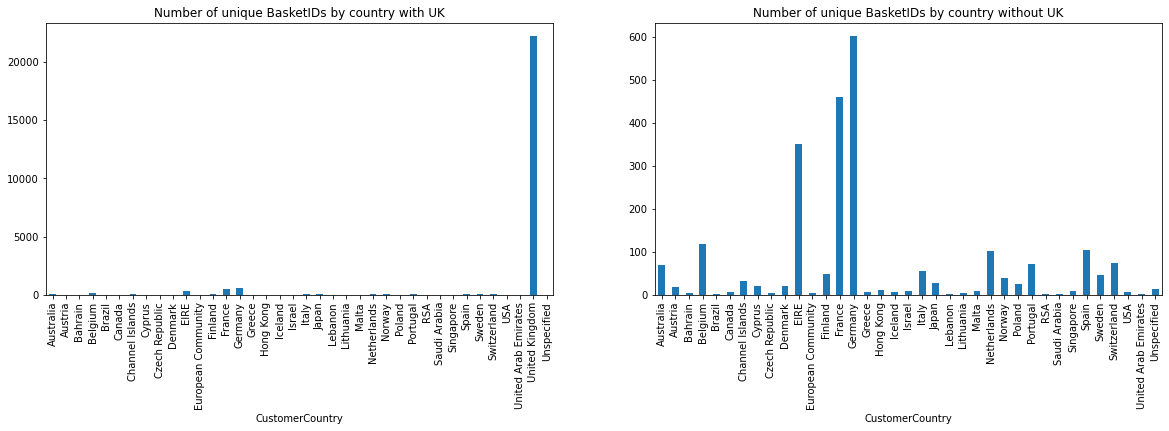

In [49]:
#Only one BasketID considered independently from the number of single entries
basketid_country = df_expl.groupby(by=["CustomerCountry"])["BasketID"].nunique()

fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))

basketid_country.plot(kind='bar')
plt.title("Number of unique BasketIDs by country with UK")

plt.subplot2grid(fig_dims, (0, 1))

basketid_country.loc[basketid_country.index != "United Kingdom"].plot(kind='bar')
plt.title("Number of unique BasketIDs by country without UK")

plt.show()

The majority of the singular operations take place in the United Kingdom.

#### Regarding missing Sale values by country

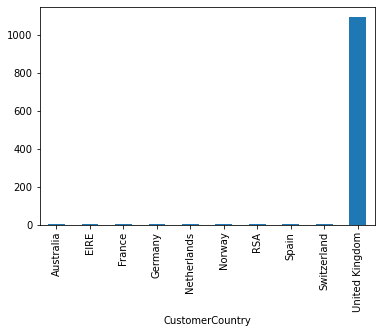

In [50]:
missing_by_country_df = df_expl.loc[df_expl["SaleNull"] == 1].groupby(by=["CustomerCountry"])["BasketID"].nunique()
missing_by_country_df.plot(kind="bar")
plt.show()

In [51]:
missing_by_country_df

CustomerCountry
Australia            3
EIRE                 3
France               1
Germany              2
Netherlands          1
Norway               1
RSA                  1
Spain                1
Switzerland          1
United Kingdom    1094
Name: BasketID, dtype: int64

It might be problematic to do data segmentation with respect to the country of a missing value (TODO).

### ProdID

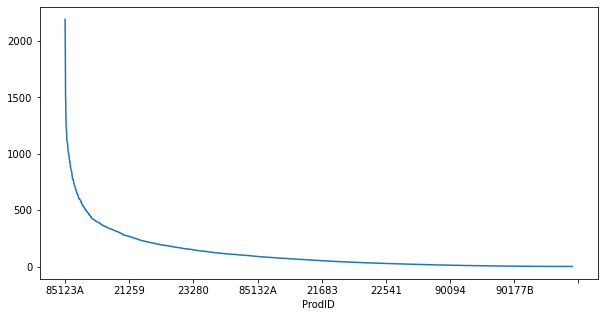

In [52]:
plt.figure(figsize=(10,5))
df["ProdID"].value_counts().plot()
plt.xlabel("ProdID")
plt.show()

#### ProdID interpretation  
Let's find out why this wasn't converted to a number.

In [53]:
df.loc[df["ProdID"].str.isnumeric(), ("ProdID", "ProdDescr")].value_counts() #Records with ProdIDs containing only numbers

ProdID  ProdDescr                        
22423   REGENCY CAKESTAND 3 TIER             2042
47566   PARTY BUNTING                        1569
20725   LUNCH BAG RED RETROSPOT              1491
84879   ASSORTED COLOUR BIRD ORNAMENT        1470
22720   SET OF 3 CAKE TINS PANTRY DESIGN     1332
                                             ... 
84620   BLUE GINGHAM ROSE CUSHION COVER         1
22181   check                                   1
23427   damaged                                 1
23035   check                                   1
20867   ?                                       1
Length: 3279, dtype: int64

In [54]:
df.loc[df["ProdID"].str.isalpha(), ("ProdID", "ProdDescr")].value_counts() #Records with ProdIDs containing only letters

ProdID     ProdDescr                 
POST       POSTAGE                       1221
M          Manual                         506
DOT        DOTCOM POSTAGE                 338
D          Discount                        77
S          SAMPLES                         26
AMAZONFEE  AMAZON FEE                      17
CRUK       CRUK Commission                 16
DCGSSBOY   BOYS PARTY BAG                   6
PADS       PADS TO MATCH ALL CUSHIONS       4
DCGSSGIRL  GIRLS PARTY BAG                  4
B          Adjust bad debt                  2
m          Manual                           1
dtype: int64

In [55]:
#Records with ProdID terminating with a letter
term_letter_prodid = df.loc[(df["ProdID"].str.slice(start=-1).str.isalpha()) & (df["ProdID"].str.slice(0, -1).str.isnumeric())]
term_letter_prodid[["ProdID", "ProdDescr"]].sort_values(by="ProdID").value_counts()

ProdID  ProdDescr                         
85123A  WHITE HANGING HEART T-LIGHT HOLDER    2182
85099B  JUMBO BAG RED RETROSPOT               1917
82494L  WOODEN FRAME ANTIQUE WHITE             880
85099C  JUMBO  BAG BAROQUE BLACK WHITE         809
85099F  JUMBO BAG STRAWBERRY                   761
                                              ... 
35817P  ACRYLIC JEWEL SNOWFLAKE,PINK             1
85017C  adjustment                               1
        Found                                    1
62096B  PURPLE/TURQ FLOWERS HANDBAG              1
84201C  HAPPY BIRTHDAY CARD TEDDY/CAKE           1
Length: 1100, dtype: int64

The presence of letters seems to indicate different variations of the same item.  

#### Regarding the possibility of having multiple entries for the same (BasketID, ProdID) entry

In [56]:
ambiguous_df = df_expl.groupby(["BasketID", "ProdID"]).filter(lambda x: x.shape[0] > 1)
ambiguous_df.sort_values(["BasketID", "ProdID"]).head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,QtaPositive,SalePositive,BasketIDTypeA,BasketIDTypeC,BasketIDTypeStd,NewBasketID,ProdSaleQta,AbsProdSaleQta,SaleNull,CustomerIDNull
113,536381,2010-01-12 09:41:00,1.25,15311,United Kingdom,71270,PHOTO CLIP LINE,1,1,1,0,0,1,536381,1.25,1.25,0,0
125,536381,2010-01-12 09:41:00,1.25,15311,United Kingdom,71270,PHOTO CLIP LINE,3,1,1,0,0,1,536381,3.75,3.75,0,0
494,536409,2010-01-12 11:45:00,1.25,17908,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1,1,1,0,0,1,536409,1.25,1.25,0,0
517,536409,2010-01-12 11:45:00,1.25,17908,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1,1,1,0,0,1,536409,1.25,1.25,0,0
485,536409,2010-01-12 11:45:00,4.95,17908,United Kingdom,22111,SCOTTIE DOG HOT WATER BOTTLE,1,1,1,0,0,1,536409,4.95,4.95,0,0


In [57]:
print(ambiguous_df.shape[0])

19594


The tuple (BasketID, ProdID) is, counterintuitively, not a "Key" of the dataset.  
It shouldn't matter too much for the purpouse of our analysis but it could prove tricky in other situations.

#### Regarding ProdIDs in type C BasketID records

In [58]:
df_expl.loc[(df_expl["BasketIDTypeC"] == 1)].groupby(["ProdID"]).apply(lambda x: x["Qta"].sum()).sort_values()

ProdID
23843    -80995
23166    -74494
84347     -9376
M         -4024
21108     -3150
          ...  
85025B       -1
85025C       -1
22869        -1
21389        -1
22824        -1
Length: 1939, dtype: int64

These are the most returned products by quantity.

In [59]:
df_expl.loc[(df_expl["BasketIDTypeC"] == 1)].groupby(["ProdID"]).apply(lambda x: x["ProdSaleQta"].sum()).sort_values()

ProdID
23843       -168469.60
M           -126877.44
AMAZONFEE   -110541.75
23166        -77479.64
POST         -11415.13
               ...    
23185            -0.29
51020B           -0.29
16235            -0.21
21883            -0.19
85204            -0.12
Length: 1939, dtype: float64

These are the most returned products by total sale value.  
The presence of items such as AMAZONFEE and M (manual adjustments) seem to further justify our choice of not considering each type C entry as connected with a standard type one.

### Qta

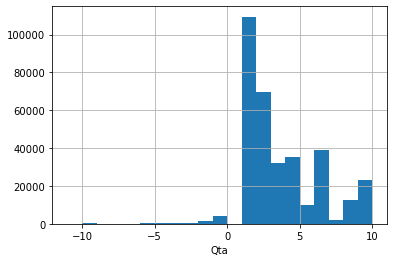

In [60]:
k = math.ceil(math.log(len(df["Qta"].unique()), 2) + 1) #Sturge's rule
df["Qta"].hist(bins=np.arange(-k, k))
plt.xlabel("Qta")
plt.show()

In [61]:
df["Qta"].describe()

count    471910.000000
mean         10.716533
std         231.355136
min      -80995.000000
25%           1.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Qta, dtype: float64

#### Regarding missing values

Let's check for 0 values.

In [62]:
print(df.loc[df["Qta"] == 0].size)
print(df.loc[df["Qta"].isna()].size)

0
0


There are no records with Qta equal to 0 or NaN, so we can assume that there are no records with missing values in the feature Qta.

#### Regarding negative Qta and type C BasketID

In [63]:
df_expl.corr()["QtaPositive"]

Sale              -0.046158
Qta                0.029379
QtaPositive        1.000000
SalePositive       0.183662
BasketIDTypeA      0.000299
BasketIDTypeC     -0.964446
BasketIDTypeStd    0.964338
ProdSaleQta        0.034543
AbsProdSaleQta    -0.019585
SaleNull          -0.183817
CustomerIDNull     0.021508
Name: QtaPositive, dtype: float64

As noted in the BasketID section there is a strong correlation between the sign of Qta and a BasketID of type C.  
Let's see if there is some interesting distribution in the remaining negative quantities.

In [64]:
neg_not_c = df_expl.loc[(df_expl["Qta"] < 0) & (df_expl["BasketIDTypeC"] == 0)]
neg_not_c.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,QtaPositive,SalePositive,BasketIDTypeA,BasketIDTypeC,BasketIDTypeStd,NewBasketID,ProdSaleQta,AbsProdSaleQta,SaleNull,CustomerIDNull
4347,536764,2010-02-12 14:42:00,0.0,NaN,United Kingdom,84952C,NaN,-38,0,0,0,0,1,536764,-0.0,0.0,1,1
7188,536996,2010-03-12 15:30:00,0.0,NaN,United Kingdom,22712,NaN,-20,0,0,0,0,1,536996,-0.0,0.0,1,1
7192,537000,2010-03-12 15:32:00,0.0,NaN,United Kingdom,21414,NaN,-22,0,0,0,0,1,537000,-0.0,0.0,1,1
7193,537001,2010-03-12 15:33:00,0.0,NaN,United Kingdom,21653,NaN,-6,0,0,0,0,1,537001,-0.0,0.0,1,1
7195,537003,2010-03-12 15:33:00,0.0,NaN,United Kingdom,85126,NaN,-2,0,0,0,0,1,537003,-0.0,0.0,1,1


Let's check if the trend of Sale equal 0 continues throughout the subset of records.

In [65]:
neg_not_c["Sale"].describe()

count    668.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Sale, dtype: float64

It does.  
Let's check if all CustomerIDs in the subset are Null.

In [66]:
neg_not_c.describe()["CustomerIDNull"]

count    668.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: CustomerIDNull, dtype: float64

They are all Null, as can be deduced by the min value.  
All entries not of type C and with a negative Qta have a Sale value equal to 0 and a CustomerID null.  

#### Regarding the intersection between ProdID entries with positive and negative Qtas

In [67]:
set_neg = set(df.loc[df["Qta"] < 0, "ProdID"])
set_pos = set(df.loc[df["Qta"] > 0, "ProdID"])
inter_list = list(set_pos & set_neg) #Intersection

print(len(inter_list)/len(set_pos))
print(len(inter_list)/len(set_neg))

0.568146618482189
0.9653508771929824


In [68]:
set_neg = set(df.loc[(df["Qta"] < 0) & (df["CustomerID"].notna()), "ProdID"])
set_pos = set(df.loc[(df["Qta"] > 0) & (df["CustomerID"].notna()), "ProdID"])
inter_list = list(set_pos & set_neg)
print(len(inter_list)/len(set_pos))
print(len(inter_list)/len(set_neg))

0.5186903137789904
0.9901041666666667


In both cases there are some values of ProdID present in a particular subset of the dataset that are not present in the other.  
Result needed to justify decision in customer features.

# Task 1.2: Data preparation

In [69]:
orig_df = df.copy() #Just in case

## Missing values

In [70]:
df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


In [71]:
missing_df = df.loc[df["Sale"] == 0]
print(f"Number of records with a missing Sale value: {missing_df.shape[0]}")
print(f"Number of unique ProdID of records with a missing Sale value: {len(missing_df['ProdID'].unique())}")

Number of records with a missing Sale value: 1279
Number of unique ProdID of records with a missing Sale value: 911


In [72]:
fill_df = df.copy()
fill_df.loc[fill_df["Sale"] == 0, "Sale"] = np.NaN

fill_group = fill_df.groupby(["ProdID"])\
        .apply(lambda x: x["Sale"].fillna(x.loc[x["Sale"].notna(), "Sale"].median()))

fill_df["Sale"] = fill_group.droplevel("ProdID")

We used Data Segmentation to separate the dataset into different groups depending on the ProdID and then we used the median of the non-null Sale entries to fill the missing values.  
We used the median instead of the mean in order to be less susceptible to outliers.

In [73]:
still_missing_df = fill_df.loc[fill_df['Sale'].isna()]
print(f"Number of records with missing Sale value after fill: {still_missing_df.shape[0]}")

Number of records with missing Sale value after fill: 71


A small percentage of the entries cannot have its missing value replaced using data segmentation since the only entries with those particular ProdIDs lack a non-null Sale value.  

In [74]:
df_expl.loc[still_missing_df.index].describe()

,Sale,Qta,QtaPositive,SalePositive,BasketIDTypeA,BasketIDTypeC,BasketIDTypeStd,ProdSaleQta,AbsProdSaleQta,SaleNull,CustomerIDNull
count,71.0,71.000000,71.000000,71.0,71.0,71.0,71.0,71.0,71.0,71.0,71.0
mean,0.0,-57.887324,0.140845,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
std,0.0,372.433639,0.350338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,-2376.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
25%,0.0,-18.000000,0.000000,0.0,0.0,0.0,1.0,-0.0,0.0,1.0,1.0
50%,0.0,-6.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
75%,0.0,-1.000000,0.000000,0.0,0.0,0.0,1.0,-0.0,0.0,1.0,1.0
max,0.0,1287.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


All these entries are missing a CustomerID.

In [75]:
df = fill_df

## Data cleanup 

In [76]:
df = df.drop(still_missing_df.index)

Remove all entries still without a Sale value in order to allow for clustering.  
There shouldn't be a problem with this decision, given that we are removing about 70 records from the dataset.

(Pointless for now since the customer features consider only CustomerID non-null entries)

Remove type A BasketID entries since, as noted above, they don't specify a CustomerID and are concerned with the grocery store chain debt.

In [77]:
#df = df.drop(df.loc[df["BasketID"].str.get(0) == "A"].index)

Remove records with negative Qta that do not reference a type C BasketID since they do not reference any CustomerID.  
Now all records with negative Qta are of type C.

In [78]:
#df = df.drop(df.loc[(df["BasketID"].str.get(0) != "C") & (df["Qta"] < 0)].index)

Since we don't seem to have a way to retrieve the CustomerID in case it is missing let's delete all entries without CustomerID.

In [79]:
#df = df.drop(df.loc[df["CustomerID"].isna()].index)

## Outlier analysis
Outliers in this dataset are expected to be found in the numerical attributes, therefore we will focus on Sale and Qta.

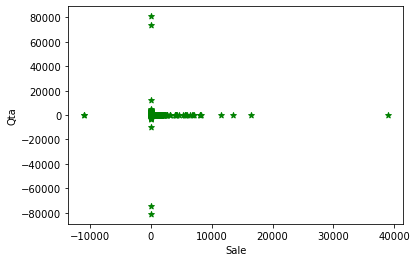

In [80]:
plt.scatter(df["Sale"], df["Qta"], color='g', marker='*', label='Standard')
plt.xlabel("Sale")
plt.ylabel("Qta")
plt.show()

### Statistical approach
As seen in the respective sections the data doesn't seem to have a normal distribution.  
They do however seem to have an exponential one. (TODO)

### IQR approach

In [81]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
right_whisker = Q3 + 1.5*IQR
left_whisker = Q1 - 1.5*IQR

In [82]:
print(f"Qta 2.5-quantile: {df['Qta'].quantile(0.025)}")
print(f"Qta 97.5-quantile: {df['Qta'].quantile(0.975)}")
print(f"Sale 2.5-quantile: {df['Sale'].quantile(0.025)}")
print(f"Sale 97.5-quantile: {df['Sale'].quantile(0.975)}\n")

print(f"Left whisker: {left_whisker}")
print(f"Right whisker: {right_whisker}")

Qta 2.5-quantile: 1.0
Qta 97.5-quantile: 60.0
Sale 2.5-quantile: 0.39
Sale 97.5-quantile: 12.75

Left whisker: Sale    -2.5
Qta    -15.5
dtype: float64
Right whisker: Sale     7.5
Qta     28.5
dtype: float64


It seems, from the scatter plot and the quantiles, that by using the IQR approach we could lose interesting information that doesn't diverge all that much from the rest, both visually and numerically, for example we would lose any Sale value greater then 12.75 while we can see that there are many data points with a greater value that are not that different (ie 99-quantile of Sale = 16.95).  

Note also that by removing the outliers in Qta with the IQR approach we will also remove all entries having a negative Qta.  
We need to consider if that data is worth keeping.  
The same concerns do not apply to Sale, as seen in the Sale section above.

In [83]:
df_wo_out_iqr = df.copy()

df_wo_out_iqr = df_wo_out_iqr.loc[(df_wo_out_iqr["Sale"] >= left_whisker["Sale"]) & (df_wo_out_iqr["Sale"] <= right_whisker["Sale"])]
df_wo_out_iqr = df_wo_out_iqr.loc[(df_wo_out_iqr["Qta"] >= left_whisker["Qta"]) & (df_wo_out_iqr["Qta"] <= right_whisker["Qta"])]

print(f'The number of total outliers in the dataset is: {df.shape[0]-df_wo_out_iqr.shape[0]}')

The number of total outliers in the dataset is: 73510


With this approach we eliminate a significant amount of all the records.

### Clustering approach

In [84]:
print(df.shape[0])
print(df.drop_duplicates(subset=["Sale", "Qta"]).shape[0])

471839
7432


We can drastically reduce the number of elements to apply the clustering algorithm on by just removing duplicates.

In [85]:
cluster_df = df.drop_duplicates(subset=["Sale", "Qta"]).copy()
cluster_sample = cluster_df[["Sale", "Qta"]].values

In [86]:
scaler = StandardScaler()
scaler.fit(cluster_sample)
norm_sample = scaler.transform(cluster_sample)

Let's first normalize the values.

In [87]:
from sklearn.cluster import DBSCAN

outlier_detection = DBSCAN(min_samples = 3, eps = 0.4) #4.3
clusters = outlier_detection.fit_predict(norm_sample)
print(f"Number of outliers among the unique data points: {list(clusters).count(-1)}")

cluster_series = pd.Series(data=clusters, index=cluster_df.index)
cluster_outliers = cluster_series.transform(lambda x: 1 if x == -1 else 0)

cluster_df["Outlier"] = cluster_outliers

Number of outliers among the unique data points: 12


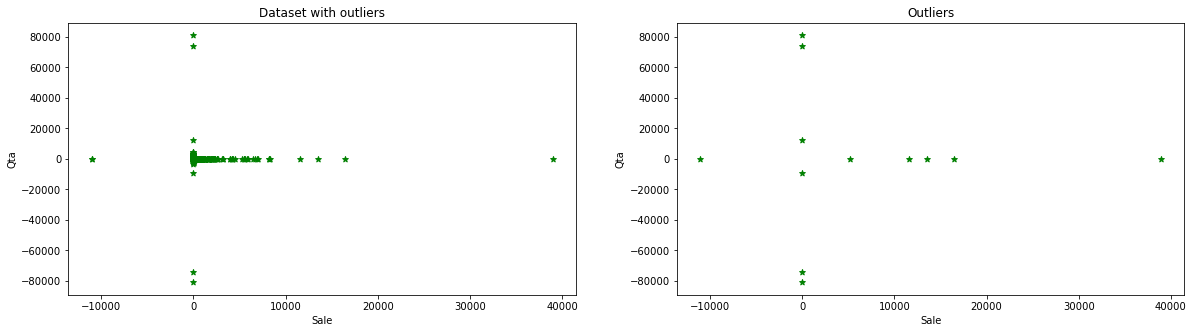

In [88]:
outlier_df = cluster_df.loc[cluster_df["Outlier"] == 1]

fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
plt.scatter(df["Sale"], df["Qta"], color="g", marker='*', label='Standard')
plt.xlabel("Sale")
plt.ylabel("Qta")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Outliers")
plt.scatter(outlier_df["Sale"], outlier_df["Qta"], color="g", marker='*', label='Standard')
plt.xlabel("Sale")
plt.ylabel("Qta")

plt.show()

This approach's result more closely matches our expectations of which data points are outliers.  
(TODO: could be useful to also take into account BasketDate)

In [89]:
outlier_tuples = outlier_df[["Sale", "Qta"]].to_numpy()
#A list consisting of the outlier couples (Sale,Qta)
outlier_list = list(zip(outlier_df["Sale"].to_numpy(), outlier_df["Qta"].to_numpy()))

df_wo_out_clustering = \
    df.groupby(["Sale", "Qta"]).filter(lambda x: not((x["Sale"].to_numpy()[0], x["Qta"].to_numpy()[0]) in outlier_list)).copy()

print(f'The number of total outliers in the dataset is: {df.shape[0]-df_wo_out_clustering.shape[0]}')

The number of total outliers in the dataset is: 13


Remove all of the data points in which the couple ("Sale", "Qta") is included in the list of couples that identify outliers.

## Outlier removal
Using the Clustering results.

In [90]:
df_wo_out = df_wo_out_clustering
df_w_out = df

We will keep both dataframes (with and without outliers) to compare the results.

## Customer features

Let's define some new features to be used for customer analysis.

In [91]:
def add_features(dest_df, source_df):

#Required features

    #Modify the data frame locally
    source_df = source_df.copy()
    
    #Additional useful data for features
    source_df["DateYear"] = source_df["BasketDate"].dt.year
    source_df["DateMonth"] = source_df["BasketDate"].dt.month
    source_df["DateDay"] = source_df["BasketDate"].dt.day
    source_df["DateWeekDay"] = source_df["BasketDate"].dt.weekday
    
    #Split the dataset into positive Qta and negative Qta in order to simplify notation
    #Note 1: CustomerID null are filtered out by groupby.
    pos_df = source_df.loc[source_df["Qta"] > 0]
    neg_df = source_df.loc[source_df["Qta"] < 0]
    
    #Total number of items bought by customer
    # Since we cannot create a clear association between the refunds and purchases,
    #  we decided to not include the negative Qta entries (type C) in this feature.
    # The negative Qtas will be considered in a separate feature. 
    IFeature = pos_df.groupby(["CustomerID"]).Qta.sum()
    dest_df = dest_df.merge(IFeature, on="CustomerID").rename(columns={"Qta":"I"})

    #Total number of unique items bought by customer
    #As seen in the Qta section, we need to limit the counting to the positive Qta entries,
    # otherwise we also will count some entries for which there is no recorded purchase entry.
    IuFeature = pos_df.groupby(["CustomerID"]).ProdID.nunique()
    dest_df = dest_df.join(IuFeature, on="CustomerID").rename(columns={"ProdID":"Iu"})

    #Max number of item bought by customer across all shopping sessions
    BasketIDQtaSum = pos_df.groupby(["CustomerID", "BasketID"]).Qta.sum()
    ImaxFeature = BasketIDQtaSum.groupby(["CustomerID"]).max()
    dest_df = dest_df.join(ImaxFeature, on="CustomerID").rename(columns={"Qta":"Imax"})
    
    #The Shannon entropy on the purchasing behaviour of the customer: types of items bought
    #Since we are assuming that the type C BasketID entries are a generic cost associated to a CustomerID,
    # we can ignore them for the purpouse of computing the entropy since they might refer to a ProdID that cannot
    # be bought Ie AMAZONFEE
    
    probSeriesGrouped = pos_df.groupby(["CustomerID"])\
            .apply(lambda x: x.groupby(["ProdID"])["Qta"].sum()/x["Qta"].sum())
    logSeriesGrouped = np.log2(probSeriesGrouped)
    ProdProbLogSeriesGrouped = -1 * probSeriesGrouped * logSeriesGrouped
    EFeature = ProdProbLogSeriesGrouped.groupby(["CustomerID"]).sum()
    EFeature = EFeature.fillna(0)
    EFeature.name = "Eproduct"
    dest_df = dest_df.join(EFeature, on="CustomerID")

#Additional features

    #Average total revenue per month
    #Revenue doesn't take into account the costs (negative Qta)
    tot_revenue_cust = pos_df.groupby(["CustomerID"]).apply(lambda x: (x["Sale"]*x["Qta"]).sum())
    n_month_cust = pos_df.groupby(["CustomerID"]).apply(lambda x: x.groupby(["DateYear", "DateMonth"]).ngroups)
    AvgFeature = tot_revenue_cust/n_month_cust
    AvgFeature.name = "AvgRevenueMonth"
    dest_df = dest_df.join(AvgFeature, on="CustomerID")
    
    #Average total costs per month
    #Note: since the entries with costs are a small amount compared to all the others,
    # some customers will have NaN as value. We will replace it with 0.
    tot_costs_cust = neg_df.groupby(["CustomerID"]).apply(lambda x: (x["Sale"]*x["Qta"]).sum())
    n_month_cust = neg_df.groupby(["CustomerID"]).apply(lambda x: x.groupby(["DateYear", "DateMonth"]).ngroups)
    AvgFeature = (tot_costs_cust/n_month_cust).abs()
    AvgFeature.name = "AvgCostsMonth"
    dest_df = dest_df.join(AvgFeature, on="CustomerID")
    dest_df["AvgCostsMonth"] = dest_df["AvgCostsMonth"].fillna(0)

    #Average customer shopping sessions per month
    #We are interested in finding out about the habits of a customer and given the percentage
    # of type C entries compared to standard ones it seems to us that costs are an unusual event
    # rather than the norm. Therefore we exclude the type C entries from our definition of shopping session.
    tot_sessions_cust = pos_df.groupby(["CustomerID"]).apply(lambda x: x["BasketID"].nunique())
    n_month_cust = pos_df.groupby(["CustomerID"]).apply(lambda x: x.groupby(["DateYear", "DateMonth"]).ngroups)
    AvgFeature = tot_sessions_cust/n_month_cust
    AvgFeature.name = "AvgSessionsMonth"
    dest_df = dest_df.join(AvgFeature, on="CustomerID")

    #The Shannon entropy on the purchasing behaviour of the customer: days of the week of shopping
    #Justification for type C entries same as for other entropy related feature.
    probSeriesGrouped = pos_df.groupby(["CustomerID"])\
        .apply(lambda x: x.groupby(["DateWeekDay"])["BasketID"].nunique()/x["BasketID"].nunique())
    logSeriesGrouped = np.log2(probSeriesGrouped)
    ProdProbLogSeriesGrouped = -1 * probSeriesGrouped * logSeriesGrouped
    EFeature = ProdProbLogSeriesGrouped.groupby(["CustomerID"]).sum()
    EFeature.name = "Eweekday"
    dest_df = dest_df.join(EFeature, on="CustomerID")
    
    return dest_df

Apply the new features to both the dataset with and without outliers.

In [92]:
unq_cust_id = df_w_out["CustomerID"].sort_values().unique()[0:-1] #Remove NaN value, last value
cust_df_w_out = pd.DataFrame(data=unq_cust_id, columns=["CustomerID"]) #Dataframe containing customer features with outliers

unq_cust_id = df_wo_out["CustomerID"].sort_values().unique()[0:-1] #Remove NaN value, last value
cust_df_wo_out = pd.DataFrame(data=unq_cust_id, columns=["CustomerID"]) #Dataframe containing customer features without outliers

cust_df_w_out["CustomerID"] = cust_df_w_out["CustomerID"].astype("object")
cust_df_wo_out["CustomerID"] = cust_df_wo_out["CustomerID"].astype("object")

cust_df_w_out = add_features(cust_df_w_out, df_w_out)
cust_df_wo_out = add_features(cust_df_wo_out, df_wo_out)

## Feature analysis

### General

In [93]:
cust_df_w_out.describe()

,I,Iu,Imax,Eproduct,AvgRevenueMonth,AvgCostsMonth,AvgSessionsMonth,Eweekday
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,1194.214566,61.489283,407.251901,4.462857,534.889846,98.944054,1.215579,0.934523
std,5055.603014,85.363900,1802.902037,1.661554,2039.584922,2900.936743,0.542591,0.862787
min,1.000000,1.000000,1.000000,0.000000,3.450000,0.000000,1.000000,0.000000
25%,160.000000,16.000000,121.000000,3.452072,196.605000,0.000000,1.000000,0.000000
50%,379.000000,35.000000,225.000000,4.593659,327.473333,0.000000,1.000000,1.000000
75%,993.000000,77.000000,408.000000,5.639521,520.664444,12.500000,1.285714,1.584963
max,197491.000000,1787.000000,80995.000000,9.575731,84236.250000,168469.600000,17.000000,2.770951


In [94]:
cust_df_wo_out.describe()

,I,Iu,Imax,Eproduct,AvgRevenueMonth,AvgCostsMonth,AvgSessionsMonth,Eweekday
count,4337.000000,4337.000000,4337.000000,4337.000000,4337.000000,4337.000000,4337.000000,4337.000000
mean,1156.086465,61.516947,368.761356,4.465145,495.460247,33.331891,1.215678,0.934723
std,4779.292580,85.373856,680.013081,1.658619,1079.814724,390.933961,0.542696,0.862869
min,1.000000,1.000000,1.000000,0.000000,2.900000,0.000000,1.000000,0.000000
25%,160.000000,16.000000,121.000000,3.453489,196.302000,0.000000,1.000000,0.000000
50%,379.000000,35.000000,224.000000,4.595984,327.300000,0.000000,1.000000,1.000000
75%,991.000000,77.000000,408.000000,5.640302,520.126667,12.450000,1.285714,1.584963
max,197491.000000,1787.000000,15049.000000,9.575731,39916.500000,22998.400000,17.000000,2.770951


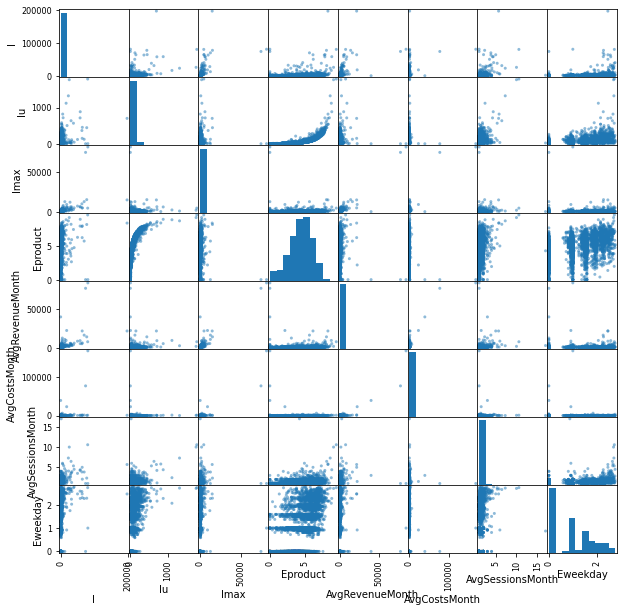

In [95]:
pd.plotting.scatter_matrix(cust_df_w_out, figsize=(10,10))
plt.show()

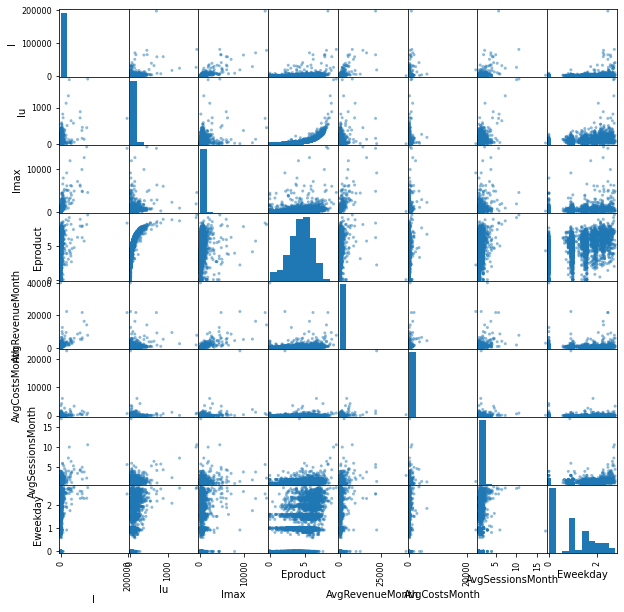

In [96]:
pd.plotting.scatter_matrix(cust_df_wo_out, figsize=(10,10))
plt.show()

Interestingly enough Eproduct seems to follow a normal distribution in both situations.

### Correlations

In [97]:
#Display correlations that have an absolute value greater than threshold
corr_w_out = cust_df_w_out.corr()

threshold = 0.5

for col in corr_w_out.columns:
    corr_w_out[col] = corr_w_out[col].transform(lambda x: x if abs(x)>threshold else 0)

corr_w_out

,I,Iu,Imax,Eproduct,AvgRevenueMonth,AvgCostsMonth,AvgSessionsMonth,Eweekday
I,1.000000,0.000000,0.579503,0.000000,0.581485,0.000000,0.0,0.000000
Iu,0.000000,1.000000,0.000000,0.677307,0.000000,0.000000,0.0,0.000000
Imax,0.579503,0.000000,1.000000,0.000000,0.916144,0.864564,0.0,0.000000
Eproduct,0.000000,0.677307,0.000000,1.000000,0.000000,0.000000,0.0,0.526303
AvgRevenueMonth,0.581485,0.000000,0.916144,0.000000,1.000000,0.868869,0.0,0.000000
AvgCostsMonth,0.000000,0.000000,0.864564,0.000000,0.868869,1.000000,0.0,0.000000
AvgSessionsMonth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
Eweekday,0.000000,0.000000,0.000000,0.526303,0.000000,0.000000,0.0,1.000000


Considering the outliers, we have a strong correlation between the maximum number of items bought in a single order by a customer and the average revenue per month.  
Other potentially interesting correlations are the ones between the average revenue and average costs, and between Imax and average costs.  
Note however that keeping these features with high correlations can be detrimental for the task of clustering.

In [98]:
#Display correlations that have an absolute value greater than threshold
corr_wo_out = cust_df_wo_out.corr()

threshold = 0.5

for col in corr_wo_out.columns:
    corr_wo_out[col] = corr_wo_out[col].transform(lambda x: x if abs(x)>threshold else 0)

corr_wo_out

,I,Iu,Imax,Eproduct,AvgRevenueMonth,AvgCostsMonth,AvgSessionsMonth,Eweekday
I,1.000000,0.00000,0.776989,0.000000,0.608341,0.0,0.0,0.000000
Iu,0.000000,1.00000,0.000000,0.677770,0.000000,0.0,0.0,0.000000
Imax,0.776989,0.00000,1.000000,0.000000,0.653974,0.0,0.0,0.000000
Eproduct,0.000000,0.67777,0.000000,1.000000,0.000000,0.0,0.0,0.526652
AvgRevenueMonth,0.608341,0.00000,0.653974,0.000000,1.000000,0.0,0.0,0.000000
AvgCostsMonth,0.000000,0.00000,0.000000,0.000000,0.000000,1.0,0.0,0.000000
AvgSessionsMonth,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,1.0,0.000000
Eweekday,0.000000,0.00000,0.000000,0.526652,0.000000,0.0,0.0,1.000000


It seems that there is a significant correlation between the max number of items bought and the average expenditure per month of the customer.  
This could suggest to us that the customers with the biggest expenditures tend to buy more items per session (further analysis required). (TODO)  
The other significant correlations don't seem particularly interesting.

In [99]:
threshold = 0.2
diff_corr = (cust_df_w_out.corr() - cust_df_wo_out.corr()).abs()

for col in diff_corr.columns:
    diff_corr[col] = diff_corr[col].transform(lambda x: x if x>threshold else 0)

print("Difference between the correlation matrices (with and without outliers)")
diff_corr

Difference between the correlation matrices (with and without outliers)


,I,Iu,Imax,Eproduct,AvgRevenueMonth,AvgCostsMonth,AvgSessionsMonth,Eweekday
I,0,0.000000,0.000000,0,0.000000,0.000000,0.00000,0
Iu,0,0.000000,0.217299,0,0.000000,0.000000,0.00000,0
Imax,0,0.217299,0.000000,0,0.262170,0.551901,0.20484,0
Eproduct,0,0.000000,0.000000,0,0.000000,0.000000,0.00000,0
AvgRevenueMonth,0,0.000000,0.262170,0,0.000000,0.456697,0.00000,0
AvgCostsMonth,0,0.000000,0.551901,0,0.456697,0.000000,0.00000,0
AvgSessionsMonth,0,0.000000,0.204840,0,0.000000,0.000000,0.00000,0
Eweekday,0,0.000000,0.000000,0,0.000000,0.000000,0.00000,0


As noted in the Outlier analysis section, by using the dataset without outliers we lose almost all of the information concerning entries with negative Qta.  

### Eproduct

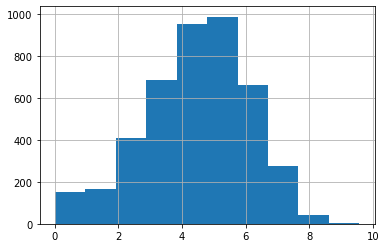

In [100]:
cust_df_w_out["Eproduct"].hist()
plt.show()

Discretize the attribute?

## Customer-related outliers analysis

In [101]:
from sklearn.cluster import DBSCAN

scaler = StandardScaler()
scaler.fit(cust_df_w_out.values)
X = scaler.transform(cust_df_w_out.values)

DBSCAN(eps=0.1, min_samples=2, algorithm='ball_tree').fit_predict(X)

array([-1, -1, -1, ..., -1, -1, -1])

## Remove customer related outliers

In [102]:
Q1 = cust_df.quantile(0.25)
Q3 = cust_df.quantile(0.75)
IQR = Q3 - Q1

NameError: name 'cust_df' is not defined

In [ ]:
#fig_height = cust_df.columns.size
#fig = plt.figure(figsize=(20, 30)) 
#fig_dims = (fig_height, 2)
#fig.subplots_adjust(hspace=0.2, wspace=0.2)
#index = 0

for feature in cust_df.columns:
    #plt.subplot2grid(fig_dims, (index, 0))
    #cust_df.boxplot(feature)

    cust_df = cust_df.loc[(cust_df[feature] >= Q1[feature] - 1.5*IQR[feature]) & (cust_df[feature] <= Q3[feature] + 1.5*IQR[feature])]
    
    #plt.subplot2grid(fig_dims, (index, 1))
    #cust_df.boxplot(feature)
    #index = index + 1
    
#plt.show()

Final result

In [ ]:
pd.plotting.scatter_matrix(cust_df, figsize=(10,10))
plt.show()

In [ ]:
cust_df.corr()

The correlation between Iu and Eweekday is even stronger after removing the outliers.  
In order to reduce the dimensionality of the data we will drop Eweekday given the strong similarity to Iu.

In [ ]:
cust_df = cust_df.drop("Eweekday", axis=1)

## Task end
Save the customer features for the next task.

In [ ]:
cust_df_w_out.to_csv("customer_features.csv", sep='\t', index=False)